In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Fetch dataset from kaggle to google colab**

In [ ]:
#kaggle API token
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'

In [ ]:
#upgrade kaggle library
!pip install --upgrade --force-reinstall --no-deps kaggle

Processing /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303/kaggle-1.5.12-cp37-none-any.whl
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
#download rcaf dataset to colab
!kaggle competitions download -c reducing-commercial-aviation-fatalities

100% 2.13G/2.13G [00:17<00:00, 109MB/s]
100% 2.13G/2.13G [00:17<00:00, 127MB/s]


In [ ]:
#unzip dataset and remove zip file
!unzip \*.zip  && rm *.zip

Archive:  reducing-commercial-aviation-fatalities.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# **1 Reducing Commercial Aviation Fatalities: Overview**

**Problem Statement -**<br> 
Reducing Commercial Aviation Fatalities is a Kaggle competition held in 2019. Aviation Fatalities/accidents cause deaths of passengers, aircrew, and complete vehicle damage, etc. Most flight-related fatalities stem from a loss of “airplane state awareness.” That is ineffective attention management on the part of pilots who may be distracted, sleepy, or in other dangerous cognitive states. 
For this problem statement to be solved, data is acquired from actual pilots in test situations, and the task is that models should be able to run calculations in real-time to monitor the cognitive states of pilots and based on observations classify the state. With the help of ML Models, pilots could then be alerted when they enter a troubling state, preventing accidents and saving lives. 

**Dataset Overview -**<br>

Dataset consists of real physiological data from 9 crews(18 pilots) who were subjected to various distracting events. There are 3 files provided by Kaggle, viz. Train, test, sample submission all in CSV types.<br>
**Training set** consists of a set of controlled experiments collected in a non-flight environment, outside of a flight simulator.<br>
**Test set** (abbreviated LOFT = Line Oriented Flight Training) consists of a full flight (take off, flight, and landing) in a flight simulator.<br>

Pilots experienced distractions intended to induce/produce one of the following 3 cognitive states:<br>		
**Channelized attention**:- this is an engaged state of mind where the pilot excludes other tasks and only remains focused on one task.<br>
**Diverted attention**:- it can be understood as multitasking when the pilot is involved in handling multiple things at a time and cannot properly focus which leads to a lack of decision making.<br>
**Startle/Surprise**:- this can be understood when sudden unexpected events happen during flight, events can be anything and dangerous by which the pilot gets surprised and starts focusing on handling troubling events.

**Features Overview -**<br>
**ID** - (test set and sample submission file only) A unique identifier for a crew + time combination.<br> 
**crew** - a unique id for a pair of pilots. There are 9 crews/pilots in the data.<br>
**experiment** - One of CA, DA, SS, or LOFT(only present in the test set). <br>
**time** - seconds into the experiment<br>
**seat** - is the pilot in the left (0) or right (1) seat<br>
**event** - The state of the pilot at the given time. This a class label.

**Physological features**:<br>
**EEG**	-	Electroencephalography(EEG) is an electrophysiological monitoring method to record the electrical activity of the brain. <br>

**ECG** - An electrocardiogram is a test that measures the heart's electrical activity. It’s also known as an ECG or EKG. Every heartbeat is triggered by an electrical signal that starts at the top of the heart and travels to the bottom. The sensor had a resolution/bit of .012215 µV and a range of -100mV to +100mV. The data are provided in microvolts.<br>

**respiration**(r) - Respiration, a measure of the rise and fall of the chest. The sensor had a resolution/bit of .2384186 µV and a range of -2.0V to +2.0V. The data are provided in microvolts.<br>

**GSR** - Galvanic Skin Response, a measure of electrodermal activity. The sensor had a resolution/bit of .2384186 µV and a range of -2.0V to +2.0V. The data are provided in microvolts.<br>

**Performance Metric -**<br>
This Kaggle problem statement is a 4 class classification problem and evaluation to be done using **Multi-Class Log Loss** between the predicted probabilities and the observed target.
Following are 4 Class Labels to be classified:
A = baseline
B = SS
C = CA
D = DA<br>

**Why Multiclass Log-Loss as evaluation metrics?**<br>
* In our case, we are solving classification problem in which Machine Learning model have to predict each class among 4 classes.
* In this problem getting misclassified prediction cannot be tolerated as per Business perspective, using Multi-Class log loss will penalize even small deviations from actual output which is very helpful.
* when data is highly imbalanced ROC curve is not a good choice to go with.

**Statistical modelling approach -**<br>

This problem can be solved by statistical modelling approach using Linear Discriminent analysis(LDA) considering the classification problem.<br>
**Learning in LDA models**: <br>
* LDA assumes data is normally distributed and each feature has same variance also values each feature differ around the mean.
* with these assumptions LDA model will estimate mean and variance for each class in training data.
* The mean(mu) of each feature(x) for each class can be defined as  "Dividing sum of features by total number of features".
                                    muk = sum(x)/nk
                


**Prediction in LDA models**:<br>   
* LDA estimates probability for each query point to which class it belongs to. class with highest probability will be declared as final predition.
* LDA model uses Bayes theorem to estimate probabilities.
                

**Why need ML approach to solve this problem? -**<br>

* If the provided Dataset was well seperated, this problem would have been solved by Statistical modelling without using any Machine learning technique, But in this case Dataset is mixed and Dataset attributes are overlapped mostly, It becomes hard to separate with only Statistical methods, to handle this problem we will Use machine learning approach.
* Another reason is Machine Learning approach will give better insights about the data by understanding patterns in data and feature extraction.
* Another thing to add, as Statistical Modeling works fairly well on small datasets else it might end up overfit whereas Machine Learning approach does really well with Large number of Rows and Columns.

# **2 Importing required libraries**

In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import joblib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler

# **3 Data Exploration**

Memory optimization function to reduce memory.

In [2]:
#https://www.kaggle.com/hanhdao123/reducing-aviation-fatalities
def reduce_mem_usage_train(df):
    """ 
    iterate through all the columns of a dataframe and modify the data type to reduce memory usage.    
    """
    #check memory usage before optimization
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        #convert all float64 to float32
        df[col] = df[col].astype(np.float32)
                               
        
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def reduce_mem_usage_test(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## **Load Datasets**

**Load train data**

In [3]:
%%time
#Load train data
train = pd.read_csv("/content/train.csv")

CPU times: user 16 s, sys: 2.61 s, total: 18.6 s
Wall time: 26.1 s


In [4]:
#Top 5 rows in train data
train.head()

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event
0,1,CA,0.011719,1,-5.28545,26.775801,-9.527310,-12.793200,16.717800,33.737499,23.712299,-6.695870,29.232100,24.842899,3.92134,18.447001,1.07547,3.09029,37.368999,17.437599,19.201900,20.5968,-3.95115,14.507600,-4520.0,817.705994,388.829987,A
1,1,CA,0.015625,1,-2.42842,28.430901,-9.323510,-3.757230,15.969300,30.443600,21.010300,-6.474720,26.641399,24.138800,5.46991,20.510599,2.83354,7.10177,31.170799,19.399700,19.689501,21.3547,1.33212,17.750200,-4520.0,817.705994,388.829987,A
2,1,CA,0.019531,1,10.67150,30.420200,15.350700,24.724001,16.143101,32.142799,25.431801,-0.088707,28.119900,26.891300,8.57886,23.162901,4.51993,12.70550,-12.012600,19.396299,23.171700,22.4076,1.53786,22.247000,-4520.0,817.705994,388.829987,A
3,1,CA,0.023438,1,11.45250,25.609800,2.433080,12.412500,20.533300,31.494101,19.142799,-0.256516,30.653601,24.247000,8.64310,19.961901,7.27575,11.45980,18.574100,23.156401,22.641199,19.3367,2.54492,18.998600,-4520.0,817.705994,388.829987,A
4,1,CA,0.027344,1,7.28321,25.942600,0.113564,5.748000,19.833599,28.753599,20.572100,-1.953470,31.722601,25.155500,12.50030,18.746901,7.30976,8.00805,6.555440,22.754700,22.670300,20.2932,1.69962,22.812799,-4520.0,817.705994,388.829987,A


**load test data**

In [3]:
%%time
#Load test data 
test = pd.read_csv("/content/test.csv")

CPU times: user 1min 1s, sys: 13.7 s, total: 1min 15s
Wall time: 1min 46s


In [4]:
#dataframe before optimization
test.head()

,id,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr
0,0,1,LOFT,0.000000,0,17.899500,6.127830,0.994807,-28.206200,-47.695499,-187.080002,-33.183498,-4.220780,8.178160,33.160301,33.812500,21.744699,16.293800,-7.044480,-14.405100,-4.03384,-0.393799,31.83810,17.075600,-8.137350,-7323.120117,643.177002,594.778992
1,1,1,LOFT,0.000000,1,45.883202,94.749001,23.290800,1.392000,2.060940,-5.145290,6.395940,33.420101,-295.013000,8.373170,29.636400,16.223000,850.288025,19.887501,-215.179001,2.11832,7.340940,9.66785,1169.239990,-0.024414,-3335.080078,826.724976,136.235001
2,2,1,LOFT,0.003906,0,33.120098,28.356501,-7.239220,-7.690860,-25.833799,-107.236000,12.845200,1.215280,13.317000,44.435101,37.585800,29.073000,22.316099,-7.642560,-10.363600,10.95050,6.513360,36.01860,24.356600,0.956158,-7323.120117,643.177002,594.778992
3,3,1,LOFT,0.003906,1,43.280102,95.887001,18.702299,-1.432890,-4.232600,-8.021180,7.427430,27.345699,-310.165009,5.389070,27.733999,7.217500,816.679016,13.826600,-214.223007,-4.91354,3.504520,3.87811,1159.400024,-0.047607,-3335.080078,826.724976,136.235001
4,4,1,LOFT,0.007812,0,7.929110,3.460380,-10.860800,-26.366699,-25.894699,37.007900,-50.334202,-11.676400,-1.143860,-17.600500,34.075600,22.912399,19.033800,2.045450,-20.788799,-3.61418,-7.539830,3.08397,13.647900,1.473720,-7323.120117,643.177002,594.778992


In [5]:
#reduce memory for dataframe
test = reduce_mem_usage_test(test)
#dataframe after optimization
test.head()

Memory usage of dataframe is 3837.77 MB
Memory usage after optimization is: 942.31 MB
Decreased by 75.4%


,id,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr
0,0,1,LOFT,0.000000,0,17.906250,6.128906,0.994629,-28.203125,-47.687500,-187.125000,-33.187500,-4.222656,8.179688,33.156250,33.812500,21.750000,16.296875,-7.042969,-14.406250,-4.035156,-0.393799,31.843750,17.078125,-8.140625,-7324.0,643.0,595.00
1,1,1,LOFT,0.000000,1,45.875000,94.750000,23.296875,1.391602,2.060547,-5.144531,6.394531,33.406250,-295.000000,8.375000,29.640625,16.218750,850.500000,19.890625,-215.125000,2.119141,7.339844,9.664062,1169.000000,-0.024414,-3336.0,826.5,136.25
2,2,1,LOFT,0.003906,0,33.125000,28.359375,-7.238281,-7.691406,-25.828125,-107.250000,12.843750,1.214844,13.320312,44.437500,37.593750,29.078125,22.312500,-7.640625,-10.367188,10.953125,6.511719,36.031250,24.359375,0.956055,-7324.0,643.0,595.00
3,3,1,LOFT,0.003906,1,43.281250,95.875000,18.703125,-1.432617,-4.234375,-8.023438,7.425781,27.343750,-310.250000,5.390625,27.734375,7.218750,816.500000,13.828125,-214.250000,-4.914062,3.503906,3.878906,1159.000000,-0.047607,-3336.0,826.5,136.25
4,4,1,LOFT,0.007812,0,7.929688,3.460938,-10.859375,-26.359375,-25.890625,37.000000,-50.343750,-11.679688,-1.143555,-17.593750,34.062500,22.906250,19.031250,2.044922,-20.781250,-3.613281,-7.539062,3.083984,13.648438,1.473633,-7324.0,643.0,595.00


In [6]:
#dropping few columns which are not useful moving further from test dataframe due to memory constraints.
#keep only physiological features
test=test.drop(columns=['experiment','crew', 'seat', 'time', 'id'])

In [7]:
test.columns

Index(['eeg_fp1', 'eeg_f7', 'eeg_f8', 'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3',
       'eeg_fp2', 'eeg_o1', 'eeg_p3', 'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4',
       'eeg_c4', 'eeg_p4', 'eeg_poz', 'eeg_c3', 'eeg_cz', 'eeg_o2', 'ecg', 'r',
       'gsr'],
      dtype='object')

## **Basic data analysis**

Major difference between train and test data is 3 experiments performed for train set, CA, DA, SS whereas for test set there is only one experiment LOFT, another difference is id column is not present in train data but in test data.

In [ ]:
#dataset shape - total rows and total columns
print('number of rows in train data:',train.shape[0])
print('number of columns in train data:',train.shape[1])

number of rows in train data: 4867421
number of columns in train data: 28


In [ ]:
#test dataset shape - total rows and total columns
test_shape = test.shape
print('number of rows in test data:',test_shape[0])
print('number of columns in test data:',test_shape[1])

number of rows in test data: 17965143
number of columns in test data: 28


Train data is large with 4867421 observations/rows and 27 dimensions/features +1 class label in training set.<br>
Test set is very large with 17965143 rows and 28 rows.

In [ ]:
#list of all features in train
train.columns

Index(['crew', 'experiment', 'time', 'seat', 'eeg_fp1', 'eeg_f7', 'eeg_f8',
       'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3',
       'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz',
       'eeg_c3', 'eeg_cz', 'eeg_o2', 'ecg', 'r', 'gsr', 'event'],
      dtype='object')

In [ ]:
#Information about datatypes associated with each column
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4867421 entries, 0 to 4867420
Data columns (total 28 columns):
 #   Column      Dtype  
---  ------      -----  
 0   crew        int64  
 1   experiment  object 
 2   time        float64
 3   seat        int64  
 4   eeg_fp1     float64
 5   eeg_f7      float64
 6   eeg_f8      float64
 7   eeg_t4      float64
 8   eeg_t6      float64
 9   eeg_t5      float64
 10  eeg_t3      float64
 11  eeg_fp2     float64
 12  eeg_o1      float64
 13  eeg_p3      float64
 14  eeg_pz      float64
 15  eeg_f3      float64
 16  eeg_fz      float64
 17  eeg_f4      float64
 18  eeg_c4      float64
 19  eeg_p4      float64
 20  eeg_poz     float64
 21  eeg_c3      float64
 22  eeg_cz      float64
 23  eeg_o2      float64
 24  ecg         float64
 25  r           float64
 26  gsr         float64
 27  event       object 
dtypes: float64(24), int64(2), object(2)
memory usage: 1.0+ GB


In [16]:
#descriptive statistics about the dataset
train.describe()

,crew,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr
count,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06
mean,5.538783e+00,1.782358e+02,4.999531e-01,3.746336e+00,1.360002e+00,1.213644e+00,7.350926e-02,7.845481e-02,8.675488e-02,2.299909e-01,3.627284e+00,1.836475e-01,2.650569e-01,4.407218e-01,1.385392e+00,1.316266e+00,1.208597e+00,6.050047e-01,2.413972e-01,1.947635e-01,6.243715e-01,4.429119e-01,2.393738e-01,5.285460e+03,7.376090e+02,8.518467e+02
std,3.409353e+00,1.039592e+02,5.000000e-01,4.506763e+01,3.518923e+01,3.519242e+01,2.431472e+01,1.803932e+01,1.832606e+01,2.531132e+01,4.615674e+01,2.807377e+01,1.658195e+01,6.410874e+01,4.284167e+01,5.481694e+01,4.205516e+01,2.052105e+01,1.660196e+01,1.833801e+01,1.975695e+01,1.974815e+01,2.351859e+01,1.214126e+04,8.187979e+01,5.039324e+02
min,1.000000e+00,3.000000e-03,0.000000e+00,-1.361360e+03,-1.581330e+03,-1.643950e+03,-1.516640e+03,-1.220510e+03,-1.266430e+03,-1.279940e+03,-1.393480e+03,-2.887910e+03,-1.226780e+03,-2.875940e+03,-1.353410e+03,-4.064070e+03,-2.333830e+03,-1.212030e+03,-1.228030e+03,-1.229130e+03,-1.230480e+03,-6.962790e+02,-1.176370e+03,-1.858570e+04,4.820600e+02,0.000000e+00
25%,3.000000e+00,8.808100e+01,0.000000e+00,-9.200250e+00,-8.325150e+00,-8.767610e+00,-7.367240e+00,-6.102000e+00,-6.007260e+00,-6.904030e+00,-9.575000e+00,-6.657340e+00,-6.580460e+00,-7.643640e+00,-9.285550e+00,-8.055440e+00,-9.306430e+00,-7.495970e+00,-6.713860e+00,-6.774840e+00,-7.161160e+00,-7.817650e+00,-6.526950e+00,-2.550070e+03,6.631430e+02,5.241140e+02
50%,5.000000e+00,1.769297e+02,0.000000e+00,3.819020e-01,4.264100e-02,1.140390e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.893450e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.170790e-01,1.106700e-01,5.667500e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.920510e+03,7.434380e+02,7.701970e+02
75%,7.000000e+00,2.683398e+02,1.000000e+00,1.030610e+01,8.753340e+00,9.282560e+00,7.437780e+00,6.176630e+00,6.086460e+00,7.071460e+00,1.062990e+01,6.781080e+00,6.744350e+00,7.810010e+00,9.955490e+00,8.631610e+00,9.775770e+00,7.765670e+00,6.831320e+00,6.905020e+00,7.466520e+00,8.025190e+00,6.615180e+00,1.029010e+04,8.134120e+02,1.197120e+03
max,1.300000e+01,3.603711e+02,1.000000e+00,1.972240e+03,2.048790e+03,2.145710e+03,1.731880e+03,9.009370e+02,1.176540e+03,1.514820e+03,2.103300e+03,1.879330e+03,9.316270e+02,2.162230e+03,1.381370e+03,3.893330e+03,2.034170e+03,8.917290e+02,9.080890e+02,1.435800e+03,9.284070e+02,6.136690e+02,2.443550e+03,3.418830e+04,8.401840e+02,1.999860e+03


In [ ]:
#get categorical and numerical features information.
print('Categorical and Numerical features in train set:')
print()
#categorical features
categorical = train.select_dtypes(include =[np.object]).columns
print('Total categorical features:', len(categorical), '|',categorical)
print()
#numerical features
numerical = train._get_numeric_data().columns
print('Total numerical features:', len(numerical), '|',numerical)

Categorical and Numerical features in train set:

Total categorical features: 2 | Index(['experiment', 'event'], dtype='object')

Total numerical features: 26 | Index(['crew', 'time', 'seat', 'eeg_fp1', 'eeg_f7', 'eeg_f8', 'eeg_t4',
       'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3', 'eeg_pz',
       'eeg_f3', 'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz', 'eeg_c3',
       'eeg_cz', 'eeg_o2', 'ecg', 'r', 'gsr'],
      dtype='object')


## **Missing Values in dataset**

In [ ]:
#check if any null values are present in dataset.
train.isnull().any()

crew          False
experiment    False
time          False
seat          False
eeg_fp1       False
eeg_f7        False
eeg_f8        False
eeg_t4        False
eeg_t6        False
eeg_t5        False
eeg_t3        False
eeg_fp2       False
eeg_o1        False
eeg_p3        False
eeg_pz        False
eeg_f3        False
eeg_fz        False
eeg_f4        False
eeg_c4        False
eeg_p4        False
eeg_poz       False
eeg_c3        False
eeg_cz        False
eeg_o2        False
ecg           False
r             False
gsr           False
event         False
dtype: bool

train data doesn't have any null values.

## **Duplicate records**

In [ ]:
train_duplicate = train.duplicated()
print(train_duplicate.sum())

0


There are no duplicate records found in train dataset.

# **4 Features analysis and Data Visualization**

## **Class label distribution**

A    2848809
C    1652686
D     235329
B     130597
Name: event, dtype: int64


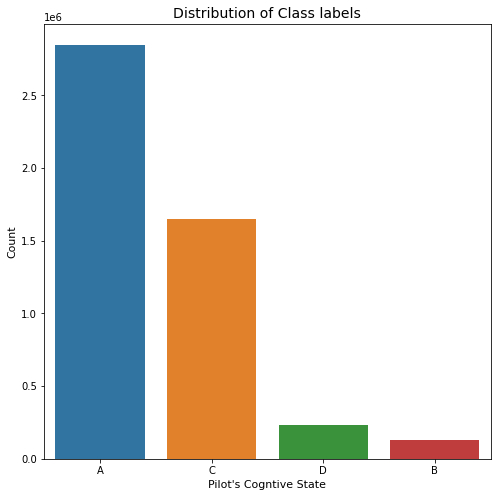

In [ ]:
#count of each label
print(train.event.value_counts())
#plot
plt.figure(figsize=(8, 8))
sns.countplot(train.event)
plt.title("Distribution of Class labels", fontsize=14)
plt.xlabel("Pilot's Cogntive State", fontsize=11)
plt.ylabel("Count", fontsize=11)
#display plot
plt.show()

from the above count plot Following are cogitive states pilot goes through according situation:<br>

A=Baseline/No event<br>
B=Startle/Surprising event<br>
C=Channelized Attention<br>
D=Diverted Attentions<br>

Also it is clearly visible that training dataset is highly imbalanced. Event 'A' occurs in highest numbers which means pilots are not distracted most of the times. event 'C' is most common occuring distracted state of mind followed by event 'D'. event 'B' has least numbers which means few times pilots goes in shocking/startle cognitive state.

## **Univariate Analysis - Physiological features - (ECG, EEGx20, GSR, Respiration**)

In [5]:
def event_based_box_violin_plots(x, y, data):
    """
    parameters-
    x: string variable to be plot on x-axis
    y: string variable to be plot on y-axis
    data: dataframe which consist of x and y variables.
    
    description-
    this function plots 2 subplots side by side - Box Plot and Violin Plot in 18,9 size image.
    plotting is based on two variables.
    """
    try:
        #main plot size
        plt.figure(figsize=(18, 9))
        #1 Box Plot
        #row=1, columns=2, plot placed=1
        plt.subplot(1, 2, 1)
        sns.boxplot(x=x,y=y,data=data)
        plt.title("Box plot for {} and {}".format(x, y))
        #2 Violin Plot
        #row=1, columns=2, plot placed=2
        plt.subplot(1, 2, 2)
        #violin plot with quartile inside violin plot
        sns.violinplot(x=x, y=y, data=data, inner='quartile')
        plt.title("Violin plot for {} and {}".format(x, y))
        #display plots
        plt.show()
    except Exception as ex:
        print(str(ex))

**ECG**

ECG is used to measure the electrical signal in the heart. ECG shows the graph of the heart’s electrical activity vs time. Using this data it’s possible to get the heartbeats count. And of course, more heartbeats can be related to a stressful event. By analyzing ECG data properly it can be inferred that when a pilot is in a normal state and when going through a stressful time. The sensor had a resolution/bit of .012215 µV and a range of -100mV to +100mV. The data are provided in microvolts.

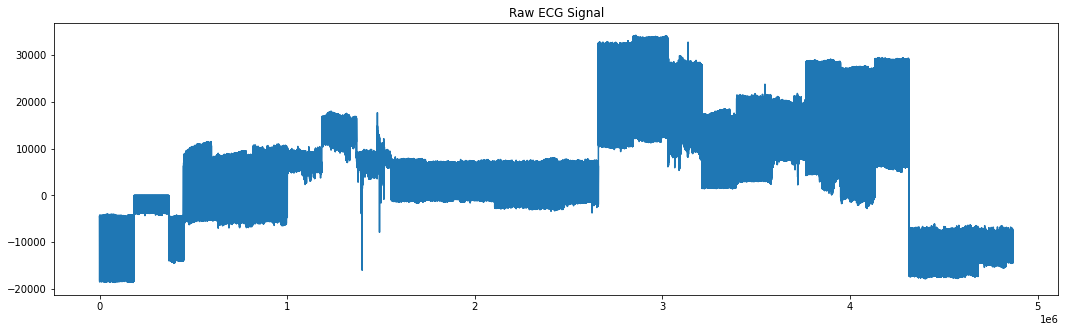

In [ ]:
plt.figure(figsize=(18, 5))
plt.plot(train.ecg)
plt.title('Raw ECG Signal')
plt.show()

from above plot its clearly visible that ECG data  is very noisy and unclear. normally ECG data is not like this.

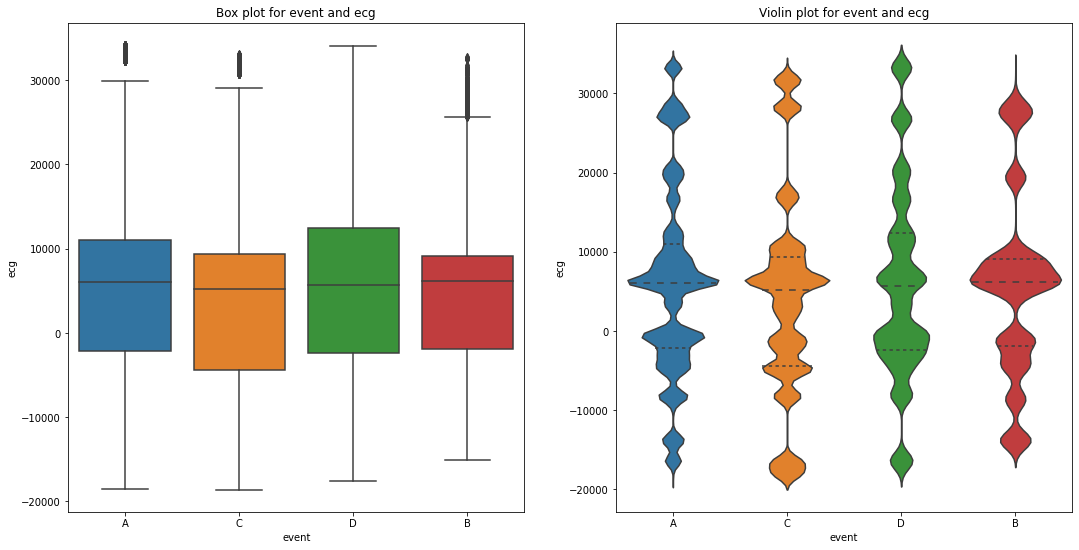

In [ ]:
event_based_box_violin_plots('event', 'ecg', train)

for event based ecg, there exists potential outliers for event A, C and B. event D has no outliers.to be assumed these outliers could be noise in the data which needs to be carefully handled as ecg data is important feature.<br>
No event share similar distribution nor their quartiles. for event A and B medians are quite close. there is clearly overlapping of distributions. None of the event is normally distributed. normallization of values is required during feature engineering. there is no symmetry shape of data points, this also means ecg feature is not normally distributed.

In [ ]:
#25th percentile
print('25th percentiles')
print('A:',train['ecg'][train['event']=='A'].quantile(0.25))
print('B:',train['ecg'][train['event']=='B'].quantile(0.25))
print('C:',train['ecg'][train['event']=='C'].quantile(0.25))
print('D:',train['ecg'][train['event']=='D'].quantile(0.25))

#75th percentile
print('\n75th percentiles')
print('A:',train['ecg'][train['event']=='A'].quantile(0.75))
print('B:',train['ecg'][train['event']=='B'].quantile(0.75))
print('C:',train['ecg'][train['event']=='C'].quantile(0.75))
print('D:',train['ecg'][train['event']=='D'].quantile(0.75))

25th percentiles
A: -2104.790039
B: -1905.890015
C: -4441.3598630000015
D: -2421.149902

75th percentiles
A: 10970.400391
B: 9111.009766
C: 9390.69043
D: 12423.099609


when value is too negative there are high chances that Pilot experience Channelized attention state. when value is >12000 pilot experience diverted attention state. this data is still not enough to conclude something strong about predictions as data cleaning and feature engineering is required to get clear ECG signals.

**EEGx20**

EEG machines are used to measure different brain waves. These brain waves are rhythmic patterns produced because of neural oscillations when the human state of consciousness changes from one to another. Example - being alert to feeling sleepy. As a human, we don't get to know when our current state of consciousness has changed but our brains know it because the way neurons fire in the central nervous system follows some rhythmic pattern.

In [ ]:
#eeg features
eeg_features=['eeg_fp1', 'eeg_f7', 'eeg_f8','eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3','eeg_pz', 'eeg_f3',
              'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz','eeg_c3', 'eeg_cz', 'eeg_o2']

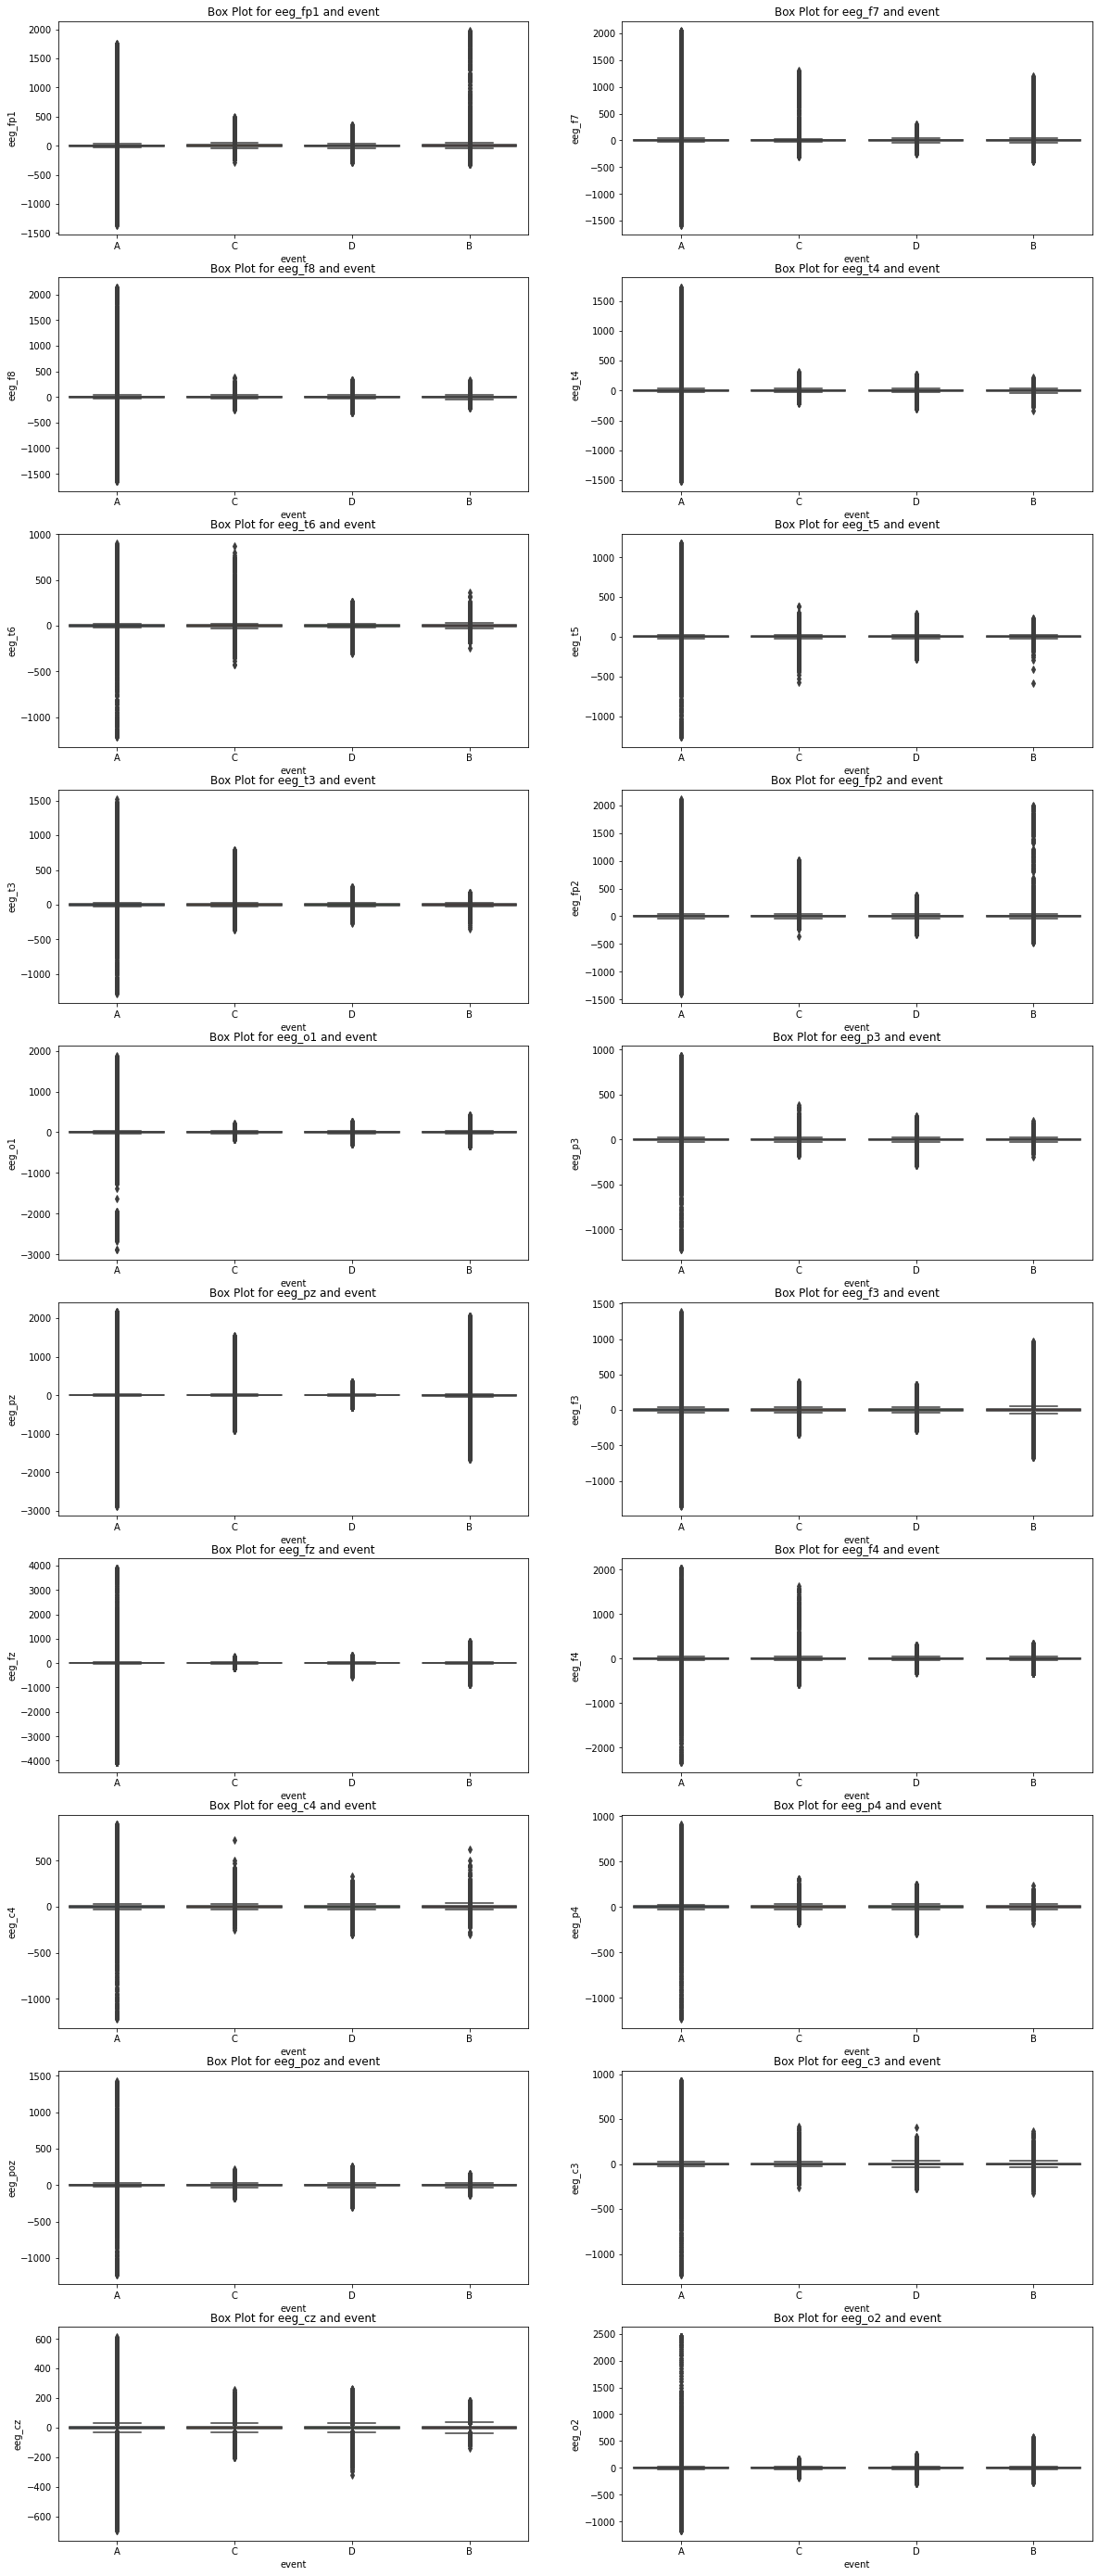

In [ ]:
i=0
#defined main plot size
plt.figure(figsize=(20,50))
for feature in eeg_features:
    #subplots in 10 rows and 2 columns results 20 subplots of 10x2 grid.
    plt.subplot(10,2,i+1) 
    sns.boxplot(x='event',y=feature,data=train)
    plt.title('Box Plot for {} and event'.format(str(feature)))
    i+=1
#display plots
plt.show()

every EEG feature w.r.t. each event consists large amount of potential outliers, this seem to be noise in the data. also almost each eeg features w.r.t. events are overlapped, which might lead to classification error, to handle this deriving new eeg features based on potential differences of electrodes could be feasible way.

**GSR**

The GSR is also known as Galvanic skin response refers to changes in sweat gland activity, it reflects the intensity of humans emotional state. Our emotional state changes according to the environment. For example, if an event is happening, joyful, stressful, threatening we experience a subsequent change in our emotional state.

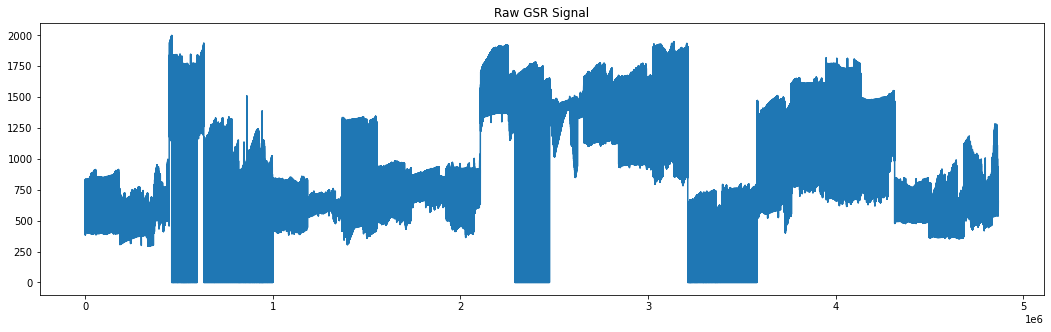

In [ ]:
plt.figure(figsize=(18, 5))
plt.plot(train.gsr)
plt.title('Raw GSR Signal')
plt.show()

from above plot its clearly visible that GSR data  is very noisy and unclear. normally GSR data is not like this.

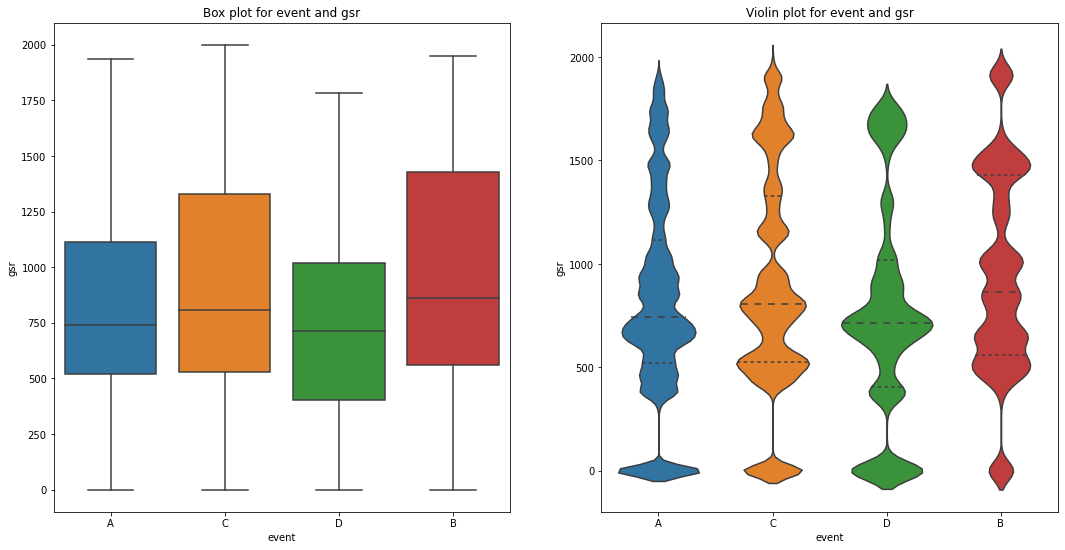

In [ ]:
event_based_box_violin_plots('event', 'gsr', train)

there are no outliers in GSR feature but from violin plot there are fewer values of A, B and C within range 100 to 300. for event D there are fewer values in range of 125 to 250. None of the event similarity in terms of distributions and no event is normally distributed this means during feature engineering its a good idea to normalize gsr values.<br>
its clear that data is not symmetric so its not normally distributted. <br>
there are no outliers as well according to box plot. <br>
according to violin plot there seem to be no values within range 100 to 350.

In [ ]:
#25th percentile
print('25th percentiles')
print('A:',train['gsr'][train['event']=='A'].quantile(0.25))
print('B:',train['gsr'][train['event']=='B'].quantile(0.25))
print('C:',train['gsr'][train['event']=='C'].quantile(0.25))
print('D:',train['gsr'][train['event']=='D'].quantile(0.25))

#75th percentile
print('\n75th percentiles')
print('A:',train['gsr'][train['event']=='A'].quantile(0.75))
print('B:',train['gsr'][train['event']=='B'].quantile(0.75))
print('C:',train['gsr'][train['event']=='C'].quantile(0.75))
print('D:',train['gsr'][train['event']=='D'].quantile(0.75))

25th percentiles
A: 518.9509889999998
B: 560.945007
C: 526.989014
D: 402.73098799999997

75th percentiles
A: 1114.060059
B: 1428.069946
C: 1327.76001
D: 1017.849976


from 1st quartile and 3rd quartile values of GSR it can be inffered that GSR becomes high when there is some stressful event, as 3rd quartile of B is highest which is Startle/Surprise event. physiologically this seems obvious that when there is stress in body our skin cells excrete more sweat.

**Respiration(r)**

In general respiration rate increases when there is some stressful event. Also as per general observation respiration is highly related to heartbeats which in this case affects ECG. respiration is a measure of the rise and fall of the chest and abdomen area. In the dataset, if the respiration rate is higher it can be inferred that the current event could be stressful.

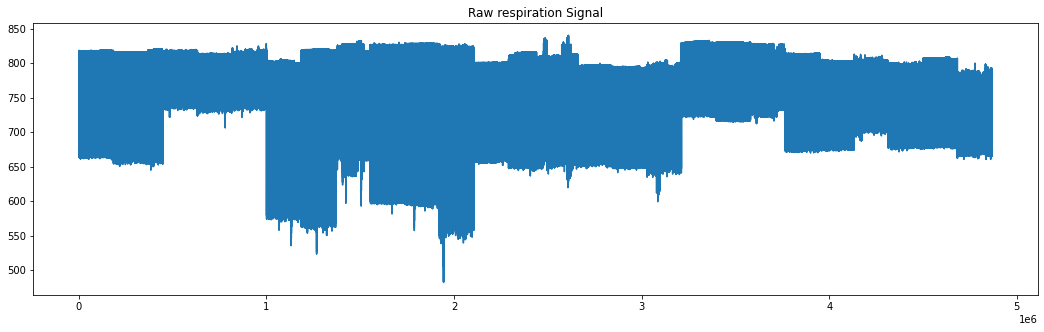

In [ ]:
plt.figure(figsize=(18, 5))
plt.plot(train.r)
plt.title('Raw respiration Signal')
plt.show()

from above plot its clearly visible that Respiration data  is very noisy and unclear. normally Respiration data is not like this instead its quite similar to sine waves.

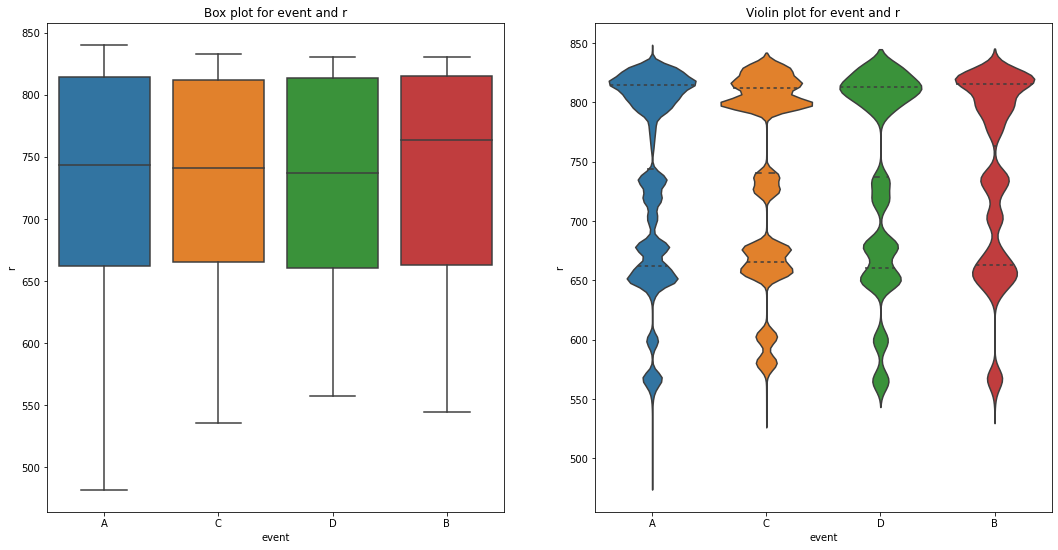

In [ ]:
event_based_box_violin_plots('event', 'r', train)

there are no outliers for any event. event C and D share quite similar distribution with nearly similar medians and interquartile range. There is no symmetry in data which means this feture is not normally distributed. also there are no potential outliers according to box plot. Normal respiration rates for an adult person at rest range from 12 to 16 breaths per minute but above figures doesn't provide clear insights.

## **Univariate Analysis - Other than Physiological features - (Crew, Experiment, Seat, Time)**

**Crew**

6     552958
4     552881
2     552868
5     552815
3     552795
7     552769
13    552724
8     549959
1     447652
Name: crew, dtype: int64



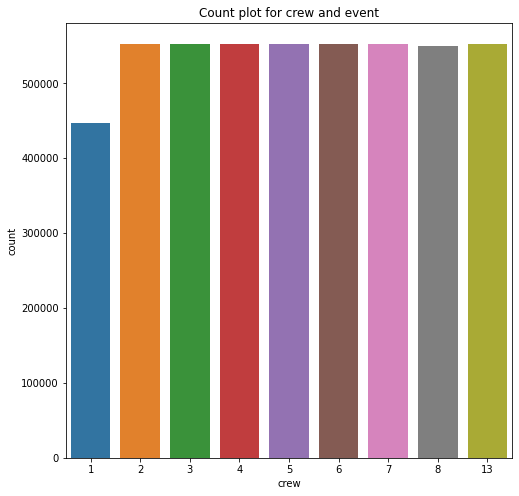

In [ ]:
#count of each pilot
print(train.crew.value_counts())
print()
#Count plot
plt.figure(figsize=(8, 8))
sns.countplot(train.crew)
plt.title("Count plot for crew and event")
plt.show()

There are total 9 crews on which experiments was performed.All crews except crew 1 have nearly similar number of experiments.

**Experiment**

DA    1658393
CA    1658376
SS    1550652
Name: experiment, dtype: int64



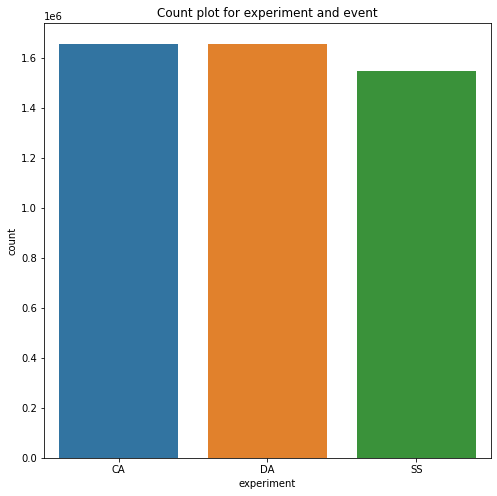

In [ ]:
print(train.experiment.value_counts())
print()
#Count plot
plt.figure(figsize=(8, 8))
sns.countplot(train.experiment)
plt.title("Count plot for experiment and event")
plt.show()

from countplot it can be seen that CA and DA experiments are almost similar but SS has less number of experiments compared to CA and DA. to balance this SMOTE or Cost sensitive methods could be experimented with, but the difference between all threes is not very large.<br>
This feature is not useful in prediction as test contains all LOFT experiments.

**Seat**

0    2433939
1    2433482
Name: seat, dtype: int64



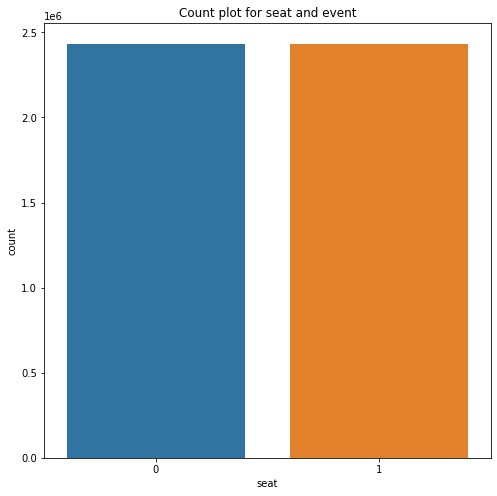

In [ ]:
print(train.seat.value_counts())
print()
#Count plot
plt.figure(figsize=(8, 8))
sns.countplot(train.seat)
plt.title("Count plot for seat and event")
plt.show()

Seat are nearly equally distributed for both pilots.

**Time**

 seconds into the experiment

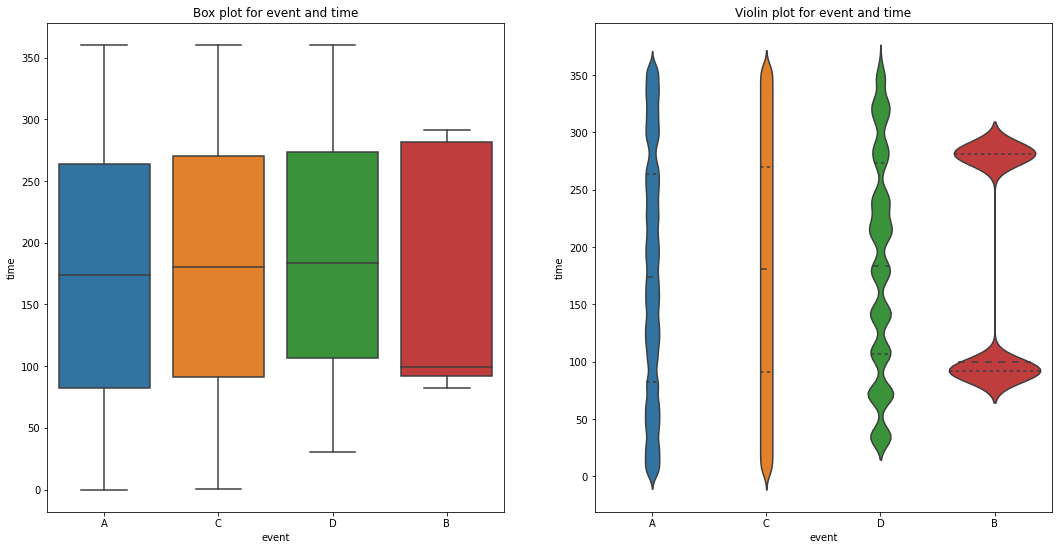

In [ ]:
event_based_box_violin_plots('event', 'time', train)

time ranges from 0 seconds to nearly 360 seconds. there are no potential outliers, this means no experiment took more than 360 seconds.

In [ ]:
#minimum maximum time for each event
print("A-min:{}, max:{}".format(train['time'][train['event']=='A'].min(), train['time'][train['event']=='A'].max()))
print("B-min:{}, max:{}".format(train['time'][train['event']=='B'].min(), train['time'][train['event']=='B'].max()))
print("C-min:{}, max:{}".format(train['time'][train['event']=='C'].min(), train['time'][train['event']=='C'].max()))
print("D-min:{}, max:{}".format(train['time'][train['event']=='D'].min(), train['time'][train['event']=='D'].max()))

A-min:0.003, max:360.21875
B-min:82.296875, max:291.53515625
C-min:0.32421875, max:360.0664063
D-min:30.734375, max:360.37109375


each experiment of A and B event took time between 0 to 360 seconds. for B it is 82 to 291. for D it is 30 to 360.

## **Bivariate analysis**

**Correlation(only Physiological features)**

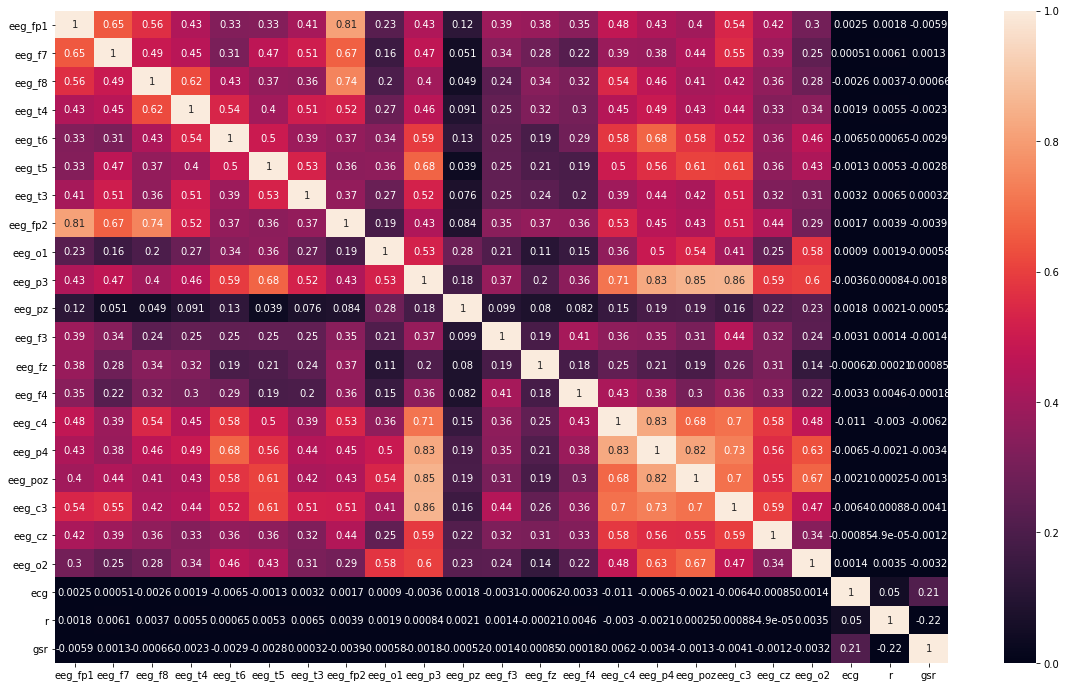

In [ ]:
#creating dataframe with only physiological features.
physiological_df = train.iloc[:,4:-1]
#defined plot size
plt.figure(figsize=(20,12))
#correlation matrix of physiological data
cor=physiological_df.corr()
#plot heatmap
sns.heatmap(cor,annot=True,vmin=0,vmax=1)
#display plot.
plt.show()

from the correlation map it can be seen that all EEG features are highly corelated but ECG, GSR, Respiration are not. but generally all physiological features have some dependecies on each others. For example: during flight, if there is any threatening and stressful event starts happening then definitely the pilot's respiration rate will change and so the same change will occur on Heartbeats this means ECG data will be automatically shown higher peaks. This will also lead to a change in the rhythm of brain waves which will be recorded at EEG data, this can lead to a change in the pilot’s state of mind from alert to mixed alert and fear. Also, all these will directly affect the dermal activity and sweat glands of the body, typically when there is a moment of fear then there is more secretion of sweat from the body cells leading to a change in an emotional state.

## **EDA: Key takeaways**<br>

* The data is highly Imbalanced.
* from Basic data analysis and EDA it it can be conclude that Physiological features are most important features which impacts Class label.
* There is noise in physiological features data which must be denoised.
* Physiological features are not normally dstributed.


# **5 Data Cleaning and separation**

## **Analyse and Remove noise from physiological features(ECG, GSR, Respiration)**

In [6]:
from scipy import signal
from scipy.signal import butter, iirnotch, lfilter, sosfilt


def signal_filter(signal, low=None, high=None, powerline=60, fs=None, order=None):
    """
    references-
    #https://towardsdatascience.com/getting-the-right-beat-e18acd48b8c1
    #https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.sosfilt.html#scipy.signal.sosfilt
    #https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html
    
    parameters-
    signal: raw signal data
    low: minimum required frequency ex. 5Hz or 50bpm
    high: maximum required frequency ex. 10Hz or 100bpm
    powerline: default Alternate current frequency 60Hz for USA
    fs: sampling rate
    order: order of the filter
    
    description-
    this is signal filter function, it filters raw signal data using scipy module.
    this function removes mainly 3 noise types - very high frequency, very low frequency and power fluctuations.
    
    
    """
    #nyquist frequency
    nyq=0.5*fs
    
    #1 handling high frequency noise
    normallized_high = high/nyq
    sos1 = butter(order, normallized_high, btype='high', analog=False, output='sos')
    x = sosfilt(sos1, signal)
    
    #2 handling low frequency noise
    normallized_low = low/nyq
    sos2 = butter(order, normallized_low, btype='low', analog=False, output='sos')
    y = sosfilt(sos2, x)
    
    #3 handling power fluctuations
    freq=powerline/nyq
    f, e = iirnotch(freq, 30)
    filtered_signal = lfilter(f, e, y)
    
    
    return filtered_signal

**Analyse and Remove noise from ECG**

"Refernce - https://towardsdatascience.com/getting-the-right-beat-e18acd48b8c1"<br>
**What is noise in ECG data and how it is accumulated?**<br>
**Answer** - The frequency range of a clean ECG signal is between 0.05 Hertz to 100 Hertz. Basically ECG Data is collected through electrodes attached to body surface so these electrodes are biological sensors, these sensors are influenced by noise from an outside source such as light, sound, power fluctuation, Muscle movement etc. this unnecessary outside information get gethered along with required data.following is the image to understand difference between clean ECG waves and noisy ECG waves.<br> 
"Image Refernce - https://www.researchgate.net/figure/Clean-artificial-ECG-signals-and-these-signals-plus-various-types-of-noise-at-various-SNR_fig8_308894350"

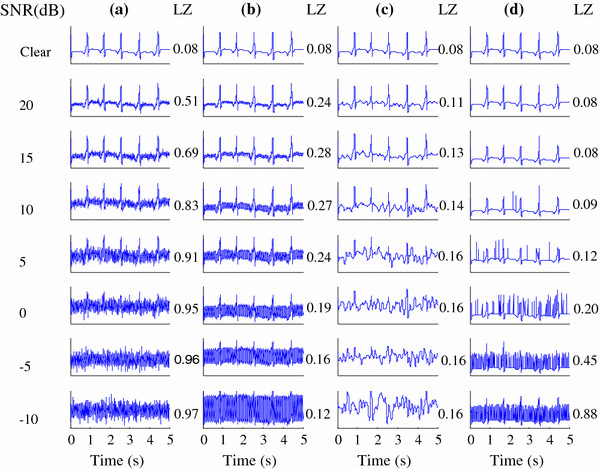

**Generally there are two types of noises in Raw ECG signals**<br>
**1 High-Frequency Noise**: gathered due to Power fluctuation Noise, muscle movement Noise.<br>
**2 Low-Frequency Noise**: gathered due to change in electrode contact. 

**Techniques to Denoise ECG Data** <br>
**1 IIR notch filters**: to remove power fluctuations.<br>
**2 FIR filters**: also known as Band-pass filters, these are stable filters. butterworth filters is most common type of FIR filters. will use FIR filters in our use case due to its working range from 1 Hz to 100 Hz.

Generally 60-80bpm is considered as healthy heart rate and when in stress it may increase by upto 38bpm. so our band of frequency is 0.5Hz to 2 Hz, hence will discard other frequencies ranging beyond requirement using below code.

**Train**

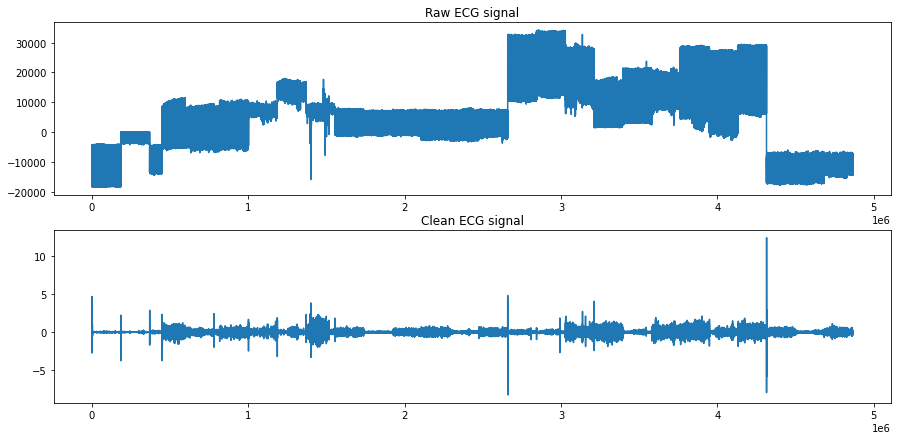

In [7]:
#train data
#filter raw ecg signal
#normally heart rate ranges from 60-100 per minute but still capturing for stressful moments it might increase further so high/max is 
#considered 200 bpm and low considered 0.5. 
filtered_ecg_signal = signal_filter(train.ecg, low=0.5, high=2, fs=1000, order=5)
train['filtered_ecg_signal'] = filtered_ecg_signal

#main plot size
plt.figure(figsize=(15, 7))
#1 Box Plot
#row=1, columns=2, plot placed=1
plt.subplot(2, 1, 1)
plt.plot(train.ecg)
plt.title("Raw ECG signal")
#2 Violin Plot
#row=1, columns=2, plot placed=2
plt.subplot(2, 1, 2)
#violin plot with quartile inside violin plot
plt.plot(filtered_ecg_signal)
plt.title("Clean ECG signal")
#display plots
plt.show()

from plots it can be seen that, lot of noice is clear when ecg data is filtered.

**Test**

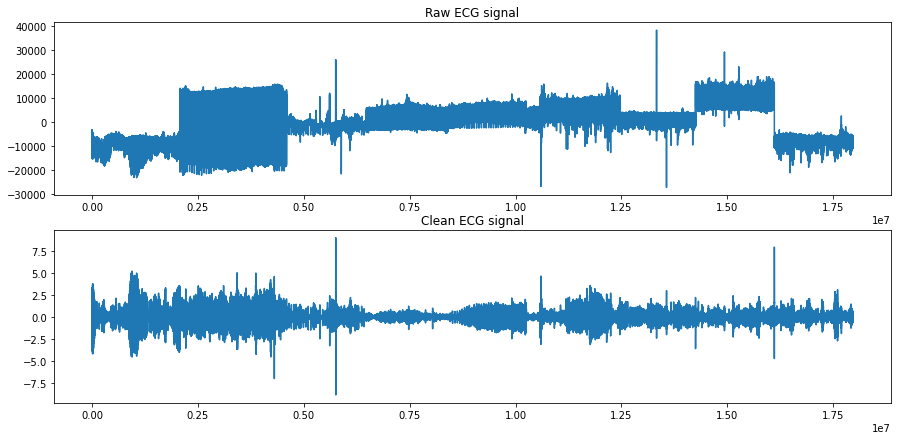

In [9]:
#test data
#filter raw ecg signal
#normally heart rate ranges from 60-100 per minute but still capturing for stressful moments it might increase further so high/max is 
#considered 200 bpm and low considered 0.5. 
filtered_ecg_signal = signal_filter(test.ecg, low=0.5, high=2, fs=1000, order=5)
test['filtered_ecg_signal'] = filtered_ecg_signal

#main plot size
plt.figure(figsize=(15, 7))
#1 Box Plot
#row=1, columns=2, plot placed=1
plt.subplot(2, 1, 1)
plt.plot(test.ecg)
plt.title("Raw ECG signal")
#2 Violin Plot
#row=1, columns=2, plot placed=2
plt.subplot(2, 1, 2)
#violin plot with quartile inside violin plot
plt.plot(filtered_ecg_signal)
plt.title("Clean ECG signal")
#display plots
plt.show()

**Analyse and Remove noise from GSR**

**Train**

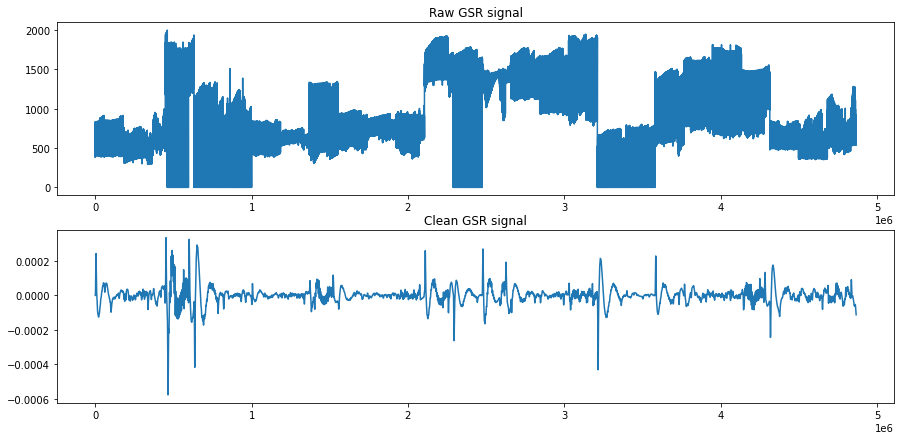

In [8]:
#train data
#filter raw ecg signal
filtered_gsr_signal = signal_filter(train.gsr, low=0.01, high=0.18, fs=1000, order=5)
#create new column
train['filtered_gsr_signal'] = filtered_gsr_signal

#main plot size
plt.figure(figsize=(15, 7))
#1 Box Plot
#row=1, columns=2, plot placed=1
plt.subplot(2, 1, 1)
plt.plot(train.gsr)
plt.title("Raw GSR signal")
#2 Violin Plot
#row=1, columns=2, plot placed=2
plt.subplot(2, 1, 2)
#violin plot with quartile inside violin plot
plt.plot(filtered_gsr_signal)
plt.title("Clean GSR signal")
#display plots
plt.show()

from plots it can be seen that, lot of noice is clear when GSR data is filtered.

**Test**

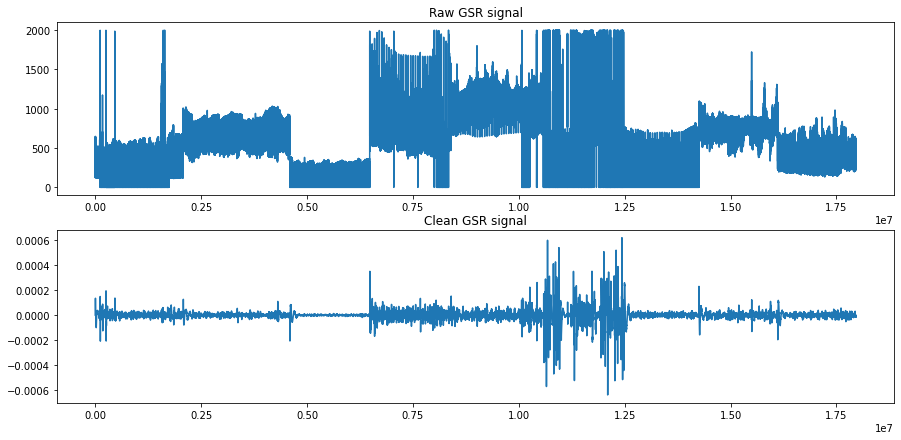

In [10]:
#test
#filter raw ecg signal
filtered_gsr_signal = signal_filter(test.gsr, low=0.01, high=0.18, fs=1000, order=5)
#create new column
test['filtered_gsr_signal'] = filtered_gsr_signal

#main plot size
plt.figure(figsize=(15, 7))
#1 Box Plot
#row=1, columns=2, plot placed=1
plt.subplot(2, 1, 1)
plt.plot(test.gsr)
plt.title("Raw GSR signal")
#2 Violin Plot
#row=1, columns=2, plot placed=2
plt.subplot(2, 1, 2)
#violin plot with quartile inside violin plot
plt.plot(filtered_gsr_signal)
plt.title("Clean GSR signal")
#display plots
plt.show()

**Analyse and Remove noise from Respiration**

Generally respiration rate is sinusoidal waves and it ranges within 12-16 breaths per minute, if shows densed data in case of respiration rate this means its noise, which is true in this problem statement. below is the image of normal respiration rate per minute. 
"Image Reference - https://www.normalbreathing.com/rate/"

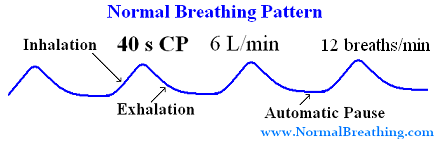

**Train**

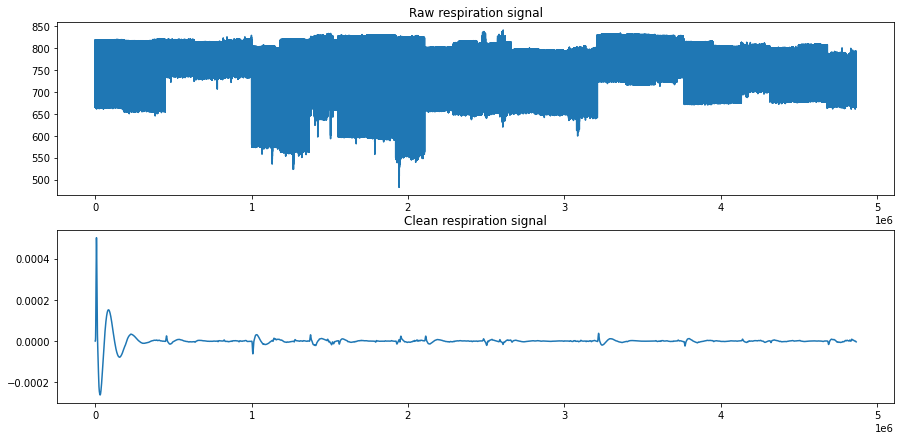

In [9]:
#train data
#filter raw respiration signal
#normal respiration rate is 12-16 breaths per minute, therefore its frequcy ranges within 0.01 to 0.2
filtered_respiration_signal = signal_filter(train.r, low=0.01, high=0.16, fs=1500, order=5)
train['filtered_respiration_signal'] = filtered_respiration_signal

#main plot size
plt.figure(figsize=(15, 7))
#1 Box Plot
#row=1, columns=2, plot placed=1
plt.subplot(2, 1, 1)
plt.plot(train.r)
plt.title("Raw respiration signal")
#2 Violin Plot
#row=1, columns=2, plot placed=2
plt.subplot(2, 1, 2)
#violin plot with quartile inside violin plot
plt.plot(filtered_respiration_signal)
plt.title("Clean respiration signal")
#display plots
plt.show()

from plots it can be seen that, lot of noice is clear when Respiration data is filtered.

**Test**

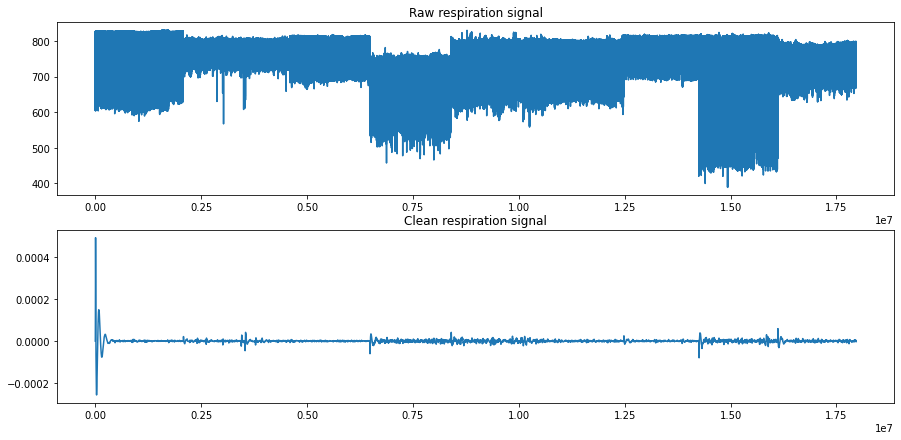

In [11]:
#test data
#filter raw respiration signal
#normal respiration rate is 12-16 breaths per minute, therefore its frequcy ranges within 0.01 to 0.2
filtered_respiration_signal = signal_filter(test.r, low=0.01, high=0.16, fs=1500, order=5)
test['filtered_respiration_signal'] = filtered_respiration_signal

#main plot size
plt.figure(figsize=(15, 7))
#1 Box Plot
#row=1, columns=2, plot placed=1
plt.subplot(2, 1, 1)
plt.plot(test.r)
plt.title("Raw respiration signal")
#2 Violin Plot
#row=1, columns=2, plot placed=2
plt.subplot(2, 1, 2)
#violin plot with quartile inside violin plot
plt.plot(filtered_respiration_signal)
plt.title("Clean respiration signal")
#display plots
plt.show()

## **Remove Columns**

**Train Data**

In [10]:
#all columns 
train.columns

Index(['crew', 'experiment', 'time', 'seat', 'eeg_fp1', 'eeg_f7', 'eeg_f8',
       'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3',
       'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz',
       'eeg_c3', 'eeg_cz', 'eeg_o2', 'ecg', 'r', 'gsr', 'event',
       'filtered_ecg_signal', 'filtered_gsr_signal',
       'filtered_respiration_signal'],
      dtype='object')

In [11]:
#dropping experiment, crew and seat column from train as it has no use moving further because here the task is to classify cognitive state 
#of pilots in which generally physiological features plays most important role.
train=train.drop(columns=['experiment','crew', 'seat', 'ecg', 'r', 'gsr', 'time'])
train.head()

,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,event,filtered_ecg_signal,filtered_gsr_signal,filtered_respiration_signal
0,-5.28545,26.775801,-9.527310,-12.793200,16.717800,33.737499,23.712299,-6.695870,29.232100,24.842899,3.92134,18.447001,1.07547,3.09029,37.368999,17.437599,19.201900,20.5968,-3.95115,14.507600,A,-4.187755e-11,1.180185e-20,3.277740e-21
1,-2.42842,28.430901,-9.323510,-3.757230,15.969300,30.443600,21.010300,-6.474720,26.641399,24.138800,5.46991,20.510599,2.83354,7.10177,31.170799,19.399700,19.689501,21.3547,1.33212,17.750200,A,-4.580381e-10,1.296377e-19,3.602110e-20
2,10.67150,30.420200,15.350700,24.724001,16.143101,32.142799,25.431801,-0.088707,28.119900,26.891300,8.57886,23.162901,4.51993,12.70550,-12.012600,19.396299,23.171700,22.4076,1.53786,22.247000,A,-2.523340e-09,7.177529e-19,1.995365e-19
3,11.45250,25.609800,2.433080,12.412500,20.533300,31.494101,19.142799,-0.256516,30.653601,24.247000,8.64310,19.961901,7.27575,11.45980,18.574100,23.156401,22.641199,19.3367,2.54492,18.998600,A,-9.485329e-09,2.713323e-18,7.547110e-19
4,7.28321,25.942600,0.113564,5.748000,19.833599,28.753599,20.572100,-1.953470,31.722601,25.155500,12.50030,18.746901,7.30976,8.00805,6.555440,22.754700,22.670300,20.2932,1.69962,22.812799,A,-2.774055e-08,7.984468e-18,2.222054e-18


**Test Data**

In [12]:
#removing redundant features
test=test.drop(columns=['ecg', 'r', 'gsr'])
test.head()

,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,filtered_ecg_signal,filtered_gsr_signal,filtered_respiration_signal
0,17.906250,6.128906,0.994629,-28.203125,-47.687500,-187.125000,-33.187500,-4.222656,8.179688,33.156250,33.812500,21.750000,16.296875,-7.042969,-14.406250,-4.035156,-0.393799,31.843750,17.078125,-8.140625,-6.785645e-11,1.805956e-20,2.577438e-21
1,45.875000,94.750000,23.296875,1.391602,2.060547,-5.144531,6.394531,33.406250,-295.000000,8.375000,29.640625,16.218750,850.500000,19.890625,-215.125000,2.119141,7.339844,9.664062,1169.000000,-0.024414,-7.052352e-10,1.844516e-19,2.906061e-20
2,33.125000,28.359375,-7.238281,-7.691406,-25.828125,-107.250000,12.843750,1.214844,13.320312,44.437500,37.593750,29.078125,22.312500,-7.640625,-10.367188,10.953125,6.511719,36.031250,24.359375,0.956055,-3.721526e-09,9.593031e-19,1.642526e-19
3,43.281250,95.875000,18.703125,-1.432617,-4.234375,-8.023438,7.425781,27.343750,-310.250000,5.390625,27.734375,7.218750,816.500000,13.828125,-214.250000,-4.914062,3.503906,3.878906,1159.000000,-0.047607,-1.351042e-08,3.444217e-18,6.308939e-19
4,7.929688,3.460938,-10.859375,-26.359375,-25.890625,37.000000,-50.343750,-11.679688,-1.143555,-17.593750,34.062500,22.906250,19.031250,2.044922,-20.781250,-3.613281,-7.539062,3.083984,13.648438,1.473633,-3.843976e-08,9.724645e-18,1.879238e-18


## **Features and class labels separation**

In [12]:
label_encoder = LabelEncoder() 
y = train['event'].values #label
y=label_encoder.fit_transform(y)
#keep only physiological features
X = train.drop(['event'], axis=1) #features
X.columns

Index(['eeg_fp1', 'eeg_f7', 'eeg_f8', 'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3',
       'eeg_fp2', 'eeg_o1', 'eeg_p3', 'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4',
       'eeg_c4', 'eeg_p4', 'eeg_poz', 'eeg_c3', 'eeg_cz', 'eeg_o2',
       'filtered_ecg_signal', 'filtered_gsr_signal',
       'filtered_respiration_signal'],
      dtype='object')

# **6 Feature Engineering**

before actually attemtpting feature engineering, will do datatypes optimization part to reduce space and memory usage for train data.

In [13]:
#reduce memory for dataframe
train = reduce_mem_usage_train(X)

Memory usage of dataframe is 854.12 MB
Memory usage after optimization is: 427.06 MB
Decreased by 50.0%


In [14]:
#dataframe after converting datatypes
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4867421 entries, 0 to 4867420
Data columns (total 23 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   eeg_fp1                      float32
 1   eeg_f7                       float32
 2   eeg_f8                       float32
 3   eeg_t4                       float32
 4   eeg_t6                       float32
 5   eeg_t5                       float32
 6   eeg_t3                       float32
 7   eeg_fp2                      float32
 8   eeg_o1                       float32
 9   eeg_p3                       float32
 10  eeg_pz                       float32
 11  eeg_f3                       float32
 12  eeg_fz                       float32
 13  eeg_f4                       float32
 14  eeg_c4                       float32
 15  eeg_p4                       float32
 16  eeg_poz                      float32
 17  eeg_c3                       float32
 18  eeg_cz                       float32
 19  

## **Derive EEG features**

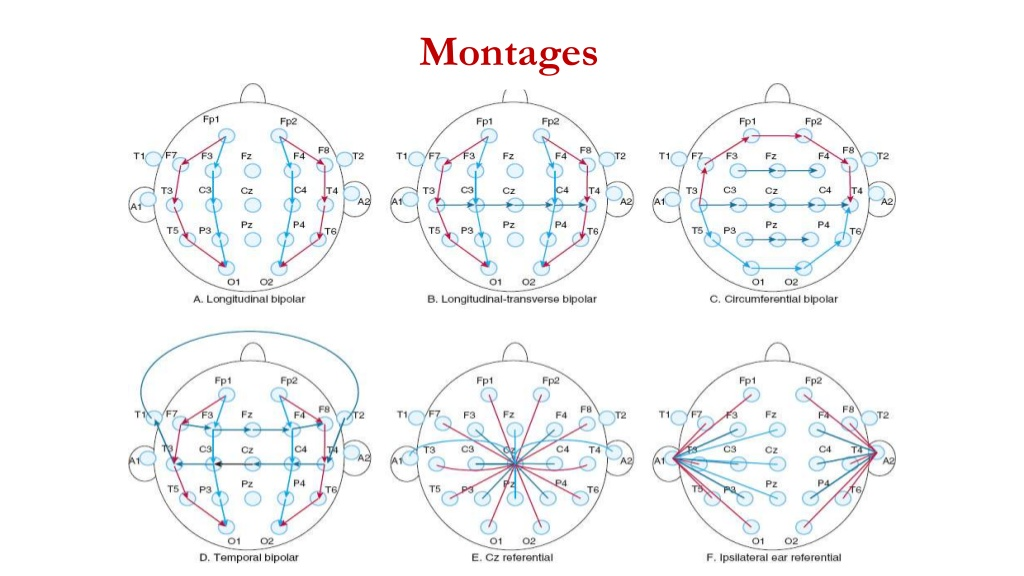

There are 2 suitable ways for this problem statement, to derive new EEG features using 'Longitudinal-Traverse Bipolar' connection(figure B) and 'Circumferential Bipolar' connection(figure C). LTB method is most commonly used by medical practitioners but CB mehtod can also be experimented with.

**Longitudinal-Traverse Bipolar method**

**Train Data**

In [15]:
#new train dataframe without eeg features, new eeg features will be added to 'train_optimized_LTB' dataset.
train_LTB=train.drop(labels=train.iloc[:,0:-3], axis=1)

In [16]:
#deriving new eeg features according to Longitudinal-Traverse Bipolar method
#Left electrodes traverse(Fp1 to O1)
train_LTB['eeg_fp1-f7'] = train['eeg_fp1']-train['eeg_f7']
train_LTB['eeg_f7-t3'] = train['eeg_f7']-train['eeg_t3']
train_LTB['eeg_t3-t5'] = train['eeg_t3']-train['eeg_t5']
train_LTB['eeg_t5-o1'] = train['eeg_t5']-train['eeg_o1']
train_LTB['eeg_fp1-f3'] = train['eeg_fp1']-train['eeg_f3']
train_LTB['eeg_f3-c3'] = train['eeg_f3']-train['eeg_c3']
train_LTB['eeg_c3-p3'] = train['eeg_c3']-train['eeg_p3']
train_LTB['eeg_p3-o1'] = train['eeg_p3']-train['eeg_o1']
#Central electrodes traverse (T3 to T4)
train_LTB['eeg_t3-c3'] = train['eeg_t3']-train['eeg_c3']
train_LTB['eeg_c3-cz'] = train['eeg_c3']-train['eeg_cz']
train_LTB['eeg_cz-c4'] = train['eeg_cz']-train['eeg_c4']
train_LTB['eeg_c4-t4'] = train['eeg_c4']-train['eeg_t4']
#Right electrodes traverse (FP2 to O2)
train_LTB['eeg_fp2-f8'] = train['eeg_fp2']-train['eeg_f8']
train_LTB['eeg_f8-t4'] = train['eeg_f8']-train['eeg_t4']
train_LTB['eeg_t4-t6'] = train['eeg_t4']-train['eeg_t6']
train_LTB['eeg_t6-o2'] = train['eeg_t6']-train['eeg_o2']
train_LTB['eeg_fp2-f4'] = train['eeg_fp2']-train['eeg_f4']
train_LTB['eeg_f4-c4'] = train['eeg_f4']-train['eeg_c4']
train_LTB['eeg_c4-p4'] = train['eeg_c4']-train['eeg_p4']
train_LTB['eeg_p4-o2'] = train['eeg_p4']-train['eeg_o2']

In [17]:
train_LTB

,filtered_ecg_signal,filtered_gsr_signal,filtered_respiration_signal,eeg_fp1-f7,eeg_f7-t3,eeg_t3-t5,eeg_t5-o1,eeg_fp1-f3,eeg_f3-c3,eeg_c3-p3,eeg_p3-o1,eeg_t3-c3,eeg_c3-cz,eeg_cz-c4,eeg_c4-t4,eeg_fp2-f8,eeg_f8-t4,eeg_t4-t6,eeg_t6-o2,eeg_fp2-f4,eeg_f4-c4,eeg_c4-p4,eeg_p4-o2
0,-4.187755e-11,1.180185e-20,3.277740e-21,-32.061249,3.063501,-10.025200,4.505400,-23.732450,-2.149799,-4.246099,-4.389200,3.115499,24.547951,-41.320148,50.162201,2.831440,3.265889,-29.511000,2.210200,-9.786160,-34.278709,19.931400,2.929999
1,-4.580381e-10,1.296377e-19,3.602110e-20,-30.859322,7.420601,-9.433300,3.802200,-22.939018,-0.844101,-2.784100,-2.502600,-0.344400,20.022579,-29.838680,34.928028,2.848790,-5.566280,-19.726530,-1.780900,-13.576490,-24.069029,11.771099,1.649500
2,-2.523340e-09,7.177529e-19,1.995365e-19,-19.748699,4.988400,-6.710999,4.022900,-12.491401,0.755301,-4.483700,-1.228600,3.024200,20.869740,13.550460,-36.736603,-15.439407,-9.373301,8.580900,-6.103899,-12.794207,24.718100,-31.408899,-2.850700
3,-9.485329e-09,2.713323e-18,7.547110e-19,-14.157300,6.467001,-12.351301,0.840500,-8.509400,0.625200,-4.910299,-6.406601,-0.193901,16.791780,-16.029181,6.161600,-2.689596,-9.979421,-8.120800,1.534700,-11.716316,-7.114301,-4.582300,4.157801
4,-2.774055e-08,7.984468e-18,2.222054e-18,-18.659389,5.370501,-8.181499,-2.969002,-11.463691,-1.546299,-4.862301,-6.567101,0.278900,18.593580,-4.855820,0.807440,-2.067034,-5.634436,-14.085599,-2.979200,-9.961520,1.452610,-16.199261,-0.058100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4867416,-1.353603e-01,-1.124845e-04,-3.836864e-06,23.292198,-44.613098,-4.823000,1.107100,-17.362103,-13.902899,-7.452610,13.680809,-9.944099,11.380100,13.033598,-7.053997,-4.766201,-4.127899,25.560699,-34.380302,-3.030201,1.190098,-20.753899,4.880301
4867417,-1.314879e-01,-1.124886e-04,-3.837548e-06,-104.324097,56.050098,37.590000,-10.564810,80.283302,-210.408997,109.155716,-0.278830,-81.851700,94.492401,-132.506393,149.932281,35.230999,-39.106411,-31.381790,15.672490,-56.685101,-97.122597,133.615219,0.607770
4867418,-1.276018e-01,-1.124926e-04,-3.838232e-06,24.858902,-46.483200,-2.990002,-5.794899,-21.627998,-14.975921,-2.702330,8.897050,-14.979621,8.682720,15.376401,-3.601801,-4.829798,-1.366301,21.498402,-33.821201,-6.103098,3.508801,-20.165421,4.240820
4867419,-1.237026e-01,-1.124966e-04,-3.838916e-06,10.050800,75.594803,-142.031403,0.692299,64.901596,-274.741302,78.705002,75.441208,-295.485291,136.800903,-114.073898,163.226410,-20.669701,19.300800,-51.112900,15.619499,-60.756298,-103.839005,47.710007,80.022995


there is no reduction/change in number of features with Longitudinal-Traverse Bipolar method.

In [18]:
#add event column to dataframe
train_LTB['event'] = y
#print dataframe
train_LTB

,filtered_ecg_signal,filtered_gsr_signal,filtered_respiration_signal,eeg_fp1-f7,eeg_f7-t3,eeg_t3-t5,eeg_t5-o1,eeg_fp1-f3,eeg_f3-c3,eeg_c3-p3,eeg_p3-o1,eeg_t3-c3,eeg_c3-cz,eeg_cz-c4,eeg_c4-t4,eeg_fp2-f8,eeg_f8-t4,eeg_t4-t6,eeg_t6-o2,eeg_fp2-f4,eeg_f4-c4,eeg_c4-p4,eeg_p4-o2,event
0,-4.187755e-11,1.180185e-20,3.277740e-21,-32.061249,3.063501,-10.025200,4.505400,-23.732450,-2.149799,-4.246099,-4.389200,3.115499,24.547951,-41.320148,50.162201,2.831440,3.265889,-29.511000,2.210200,-9.786160,-34.278709,19.931400,2.929999,0
1,-4.580381e-10,1.296377e-19,3.602110e-20,-30.859322,7.420601,-9.433300,3.802200,-22.939018,-0.844101,-2.784100,-2.502600,-0.344400,20.022579,-29.838680,34.928028,2.848790,-5.566280,-19.726530,-1.780900,-13.576490,-24.069029,11.771099,1.649500,0
2,-2.523340e-09,7.177529e-19,1.995365e-19,-19.748699,4.988400,-6.710999,4.022900,-12.491401,0.755301,-4.483700,-1.228600,3.024200,20.869740,13.550460,-36.736603,-15.439407,-9.373301,8.580900,-6.103899,-12.794207,24.718100,-31.408899,-2.850700,0
3,-9.485329e-09,2.713323e-18,7.547110e-19,-14.157300,6.467001,-12.351301,0.840500,-8.509400,0.625200,-4.910299,-6.406601,-0.193901,16.791780,-16.029181,6.161600,-2.689596,-9.979421,-8.120800,1.534700,-11.716316,-7.114301,-4.582300,4.157801,0
4,-2.774055e-08,7.984468e-18,2.222054e-18,-18.659389,5.370501,-8.181499,-2.969002,-11.463691,-1.546299,-4.862301,-6.567101,0.278900,18.593580,-4.855820,0.807440,-2.067034,-5.634436,-14.085599,-2.979200,-9.961520,1.452610,-16.199261,-0.058100,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4867416,-1.353603e-01,-1.124845e-04,-3.836864e-06,23.292198,-44.613098,-4.823000,1.107100,-17.362103,-13.902899,-7.452610,13.680809,-9.944099,11.380100,13.033598,-7.053997,-4.766201,-4.127899,25.560699,-34.380302,-3.030201,1.190098,-20.753899,4.880301,0
4867417,-1.314879e-01,-1.124886e-04,-3.837548e-06,-104.324097,56.050098,37.590000,-10.564810,80.283302,-210.408997,109.155716,-0.278830,-81.851700,94.492401,-132.506393,149.932281,35.230999,-39.106411,-31.381790,15.672490,-56.685101,-97.122597,133.615219,0.607770,0
4867418,-1.276018e-01,-1.124926e-04,-3.838232e-06,24.858902,-46.483200,-2.990002,-5.794899,-21.627998,-14.975921,-2.702330,8.897050,-14.979621,8.682720,15.376401,-3.601801,-4.829798,-1.366301,21.498402,-33.821201,-6.103098,3.508801,-20.165421,4.240820,0
4867419,-1.237026e-01,-1.124966e-04,-3.838916e-06,10.050800,75.594803,-142.031403,0.692299,64.901596,-274.741302,78.705002,75.441208,-295.485291,136.800903,-114.073898,163.226410,-20.669701,19.300800,-51.112900,15.619499,-60.756298,-103.839005,47.710007,80.022995,0


In [19]:
#save dataframe for later use
joblib.dump(train_LTB, '/content/train_LTB.pkl')

['/content/train_LTB.pkl']

In [20]:
#copy test_ltb file
!cp '/content/train_LTB.pkl' '/content/drive/MyDrive/applied aic/case studies/rcaf/train_data/train_LTB.pkl'

**Test Data**

In [13]:
test.columns

Index(['eeg_fp1', 'eeg_f7', 'eeg_f8', 'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3',
       'eeg_fp2', 'eeg_o1', 'eeg_p3', 'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4',
       'eeg_c4', 'eeg_p4', 'eeg_poz', 'eeg_c3', 'eeg_cz', 'eeg_o2',
       'filtered_ecg_signal', 'filtered_gsr_signal',
       'filtered_respiration_signal'],
      dtype='object')

In [14]:
test_LTB = test.drop(labels=test.iloc[:,0:-3], axis=1)

In [15]:
#deriving new eeg features according to Longitudinal-Traverse Bipolar method
#Left electrodes traverse(Fp1 to O1)
test_LTB['eeg_fp1-f7'] = test['eeg_fp1']-test['eeg_f7']
test_LTB['eeg_f7-t3'] = test['eeg_f7']-test['eeg_t3']
test_LTB['eeg_t3-t5'] = test['eeg_t3']-test['eeg_t5']
test_LTB['eeg_t5-o1'] = test['eeg_t5']-test['eeg_o1']
test_LTB['eeg_fp1-f3'] = test['eeg_fp1']-test['eeg_f3']
test_LTB['eeg_f3-c3'] = test['eeg_f3']-test['eeg_c3']
test_LTB['eeg_c3-p3'] = test['eeg_c3']-test['eeg_p3']
test_LTB['eeg_p3-o1'] = test['eeg_p3']-test['eeg_o1']
#Central electrodes traverse (T3 to T4)
test_LTB['eeg_t3-c3'] = test['eeg_t3']-test['eeg_c3']
test_LTB['eeg_c3-cz'] = test['eeg_c3']-test['eeg_cz']
test_LTB['eeg_cz-c4'] = test['eeg_cz']-test['eeg_c4']
test_LTB['eeg_c4-t4'] = test['eeg_c4']-test['eeg_t4']
#Right electrodes traverse (FP2 to O2)
test_LTB['eeg_fp2-f8'] = test['eeg_fp2']-test['eeg_f8']
test_LTB['eeg_f8-t4'] = test['eeg_f8']-test['eeg_t4']
test_LTB['eeg_t4-t6'] = test['eeg_t4']-test['eeg_t6']
test_LTB['eeg_t6-o2'] = test['eeg_t6']-test['eeg_o2']
test_LTB['eeg_fp2-f4'] = test['eeg_fp2']-test['eeg_f4']
test_LTB['eeg_f4-c4'] = test['eeg_f4']-test['eeg_c4']
test_LTB['eeg_c4-p4'] = test['eeg_c4']-test['eeg_p4']
test_LTB['eeg_p4-o2'] = test['eeg_p4']-test['eeg_o2']

In [16]:
#save dataframe for later use
joblib.dump(test_LTB,'/content/test_LTB.pkl')

['/content/test_LTB.pkl']

In [17]:
#copy test_ltb file
!cp '/content/test_LTB.pkl' '/content/drive/MyDrive/applied aic/case studies/rcaf/test_data/test_LTB.pkl'

## **Feature Scaling(Column standardization)**

for feature scaling I am using feature standardization, as standardization won't affect outliers. there are some outliers in features like ECG and EEG, we don't want to discard outliers for this problem as they might have important information.

In [ ]:
#object of StandardScaler
standardized = StandardScaler()

**Feature Scaling for LTB method**

standardizing all features for Longitudinal-Traverse bipolar method.

**Train Data**

In [ ]:
#standardize columns
train_LTB_standardized = standardized.fit_transform((train_LTB))
#convert numpy array to pandas dataframe
train_LTB_standardized = pd.DataFrame(train_LTB_standardized)
#assign columns
train_LTB_standardized.columns = train_LTB.columns

In [ ]:
#add event column to dataframe
train_LTB_standardized['event'] = y
#print dataframe
train_LTB_standardized

,filtered_ecg_signal,filtered_gsr_signal,filtered_respiration_signal,eeg_fp1-f7,eeg_f7-t3,eeg_t3-t5,eeg_t5-o1,eeg_fp1-f3,eeg_f3-c3,eeg_c3-p3,eeg_p3-o1,eeg_t3-c3,eeg_c3-cz,eeg_cz-c4,eeg_c4-t4,eeg_fp2-f8,eeg_f8-t4,eeg_t4-t6,eeg_t6-o2,eeg_fp2-f4,eeg_f4-c4,eeg_c4-p4,eeg_p4-o2,event
0,0.000017,0.002526,-0.000506,-0.990796,0.062082,-0.461029,0.167230,-0.537239,-0.075824,-0.451149,-0.186699,0.154520,1.369372,-2.241728,2.086796,0.013534,0.077024,-1.398095,0.107120,-0.244838,-0.914358,1.705960,0.160260,0
1,0.000017,0.002526,-0.000506,-0.956225,0.201983,-0.434192,0.141678,-0.520903,-0.041812,-0.307931,-0.107912,0.002200,1.115051,-1.616374,1.446252,0.014096,-0.242997,-0.934474,-0.073186,-0.320875,-0.646735,0.994528,0.090173,0
2,0.000017,0.002526,-0.000506,-0.636657,0.123888,-0.310765,0.149698,-0.305796,-0.000149,-0.474425,-0.054708,0.150501,1.162661,0.746872,-1.566992,-0.578305,-0.380939,0.406826,-0.268486,-0.305182,0.632106,-2.769991,-0.156141,0
3,0.000017,0.002526,-0.000506,-0.475835,0.171364,-0.566492,0.034061,-0.223810,-0.003538,-0.516215,-0.270948,0.008826,0.933483,-0.864222,0.236726,-0.165307,-0.402901,-0.384556,0.076603,-0.283559,-0.202307,-0.431194,0.227463,0
4,0.000016,0.002526,-0.000506,-0.605326,0.136157,-0.377437,-0.104362,-0.284636,-0.060104,-0.511513,-0.277651,0.029641,1.034743,-0.255650,0.011602,-0.145140,-0.245467,-0.667188,-0.127322,-0.248356,0.022255,-1.443984,-0.003291,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4867416,-0.394661,-2.130485,-0.138419,0.601303,-1.468751,-0.225165,0.043749,-0.406079,-0.381982,-0.765261,0.567929,-0.420419,0.629352,0.718721,-0.318943,-0.232573,-0.190880,1.211385,-1.545929,-0.109309,0.015374,-1.841067,0.267008,0
4867417,-0.383370,-2.130562,-0.138443,-3.069250,1.763412,1.697806,-0.380365,1.604349,-5.500784,10.657767,-0.015044,-3.586099,5.300180,-7.208307,6.281775,1.063037,-1.458277,-1.486740,0.715306,-1.185666,-2.561664,11.617146,0.033155,0
4867418,-0.372039,-2.130638,-0.138468,0.646365,-1.528798,-0.142058,-0.207044,-0.493910,-0.409933,-0.299921,0.368153,-0.642105,0.477762,0.846325,-0.173790,-0.234633,-0.090817,1.018900,-1.520671,-0.170953,0.076153,-1.789762,0.232007,0
4867419,-0.360670,-2.130715,-0.138493,0.220449,2.390967,-6.446081,0.028676,1.287654,-7.176581,7.674795,3.147124,-12.991162,7.677876,-6.204357,6.840745,-0.747728,0.658026,-2.421665,0.712912,-1.267337,-2.737719,4.127755,4.379874,0


**Save train LTB standardized dataset for later use**

In [ ]:
#save dataframe for later use
joblib.dump(train_LTB_standardized,'/content/train_LTB_standardized.pkl')

['/content/train_LTB_standardized.pkl']

In [ ]:
#copy dataset from colab to desired folder in google drive
!cp '/content/train_LTB_standardized.pkl' '/content/drive/MyDrive/applied aic/case studies/rcaf/train_data'

**Test Data**

In [ ]:
#load data
test_LTB = joblib.load('/content/drive/MyDrive/applied aic/case studies/rcaf/test_data/test_LTB.pkl')

In [ ]:
#standardize columns
test_LTB_standardized = standardized.fit_transform((test_LTB))
#convert numpy array to pandas dataframe
test_LTB_standardized = pd.DataFrame(test_LTB_standardized)
#assign columns
test_LTB_standardized.columns = test_LTB.columns
test_LTB_standardized

,filtered_ecg_signal,filtered_gsr_signal,filtered_respiration_signal,eeg_fp1-f7,eeg_f7-t3,eeg_t3-t5,eeg_t5-o1,eeg_fp1-f3,eeg_f3-c3,eeg_c3-p3,eeg_p3-o1,eeg_t3-c3,eeg_c3-cz,eeg_cz-c4,eeg_c4-t4,eeg_fp2-f8,eeg_f8-t4,eeg_t4-t6,eeg_t6-o2,eeg_fp2-f4,eeg_f4-c4,eeg_c4-p4,eeg_p4-o2
0,-7.184252e-07,-0.000014,-0.000193,0.115128,0.494528,2.156206,-0.615982,-0.032704,-0.059029,-0.020051,0.079546,-0.688129,0.093852,0.193585,0.115565,-0.114536,0.412028,0.162398,-0.110930,-0.003137,0.022083,-0.075822,0.011069
1,-7.197328e-07,-0.000014,-0.000193,-0.707024,1.154546,0.163163,0.914506,0.125211,0.020350,0.014147,0.969459,-0.029973,-7.267409,8.503184,-1.967897,0.067835,0.302966,0.004054,0.004416,0.038930,0.865510,-1.571633,0.005485
2,-7.259207e-07,-0.000014,-0.000193,0.020036,0.174399,1.682292,-0.380295,0.004491,-0.044055,-0.113300,0.099215,-0.242333,0.074449,0.213457,-0.033461,0.048129,-0.017680,0.151840,-0.075532,0.020616,0.004903,-0.154906,0.027853
3,-7.460029e-07,-0.000014,-0.000193,-0.757429,1.155387,0.217921,0.953951,0.155410,0.005021,-0.022670,1.008598,0.042702,-7.242323,8.435602,-1.935102,0.050360,0.276576,0.031316,-0.012959,0.038930,0.840037,-1.514693,-0.014480
4,-7.971461e-07,-0.000014,-0.000193,0.016012,0.689591,-1.220655,0.120565,-0.085183,0.083637,0.268937,-0.052798,-0.564852,-0.064993,0.211729,0.041211,-0.062204,0.207216,0.005627,-0.077134,-0.068219,0.079382,-0.124967,-0.015103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17965138,1.149824e-01,-0.316865,-0.188297,-0.040111,-0.080360,0.108733,0.030679,-0.062976,-0.009413,0.077716,0.057431,-0.068247,0.094538,0.061589,-0.056396,-0.001786,0.082507,0.012932,-0.011455,0.022091,0.022199,-0.036421,-0.010498
17965139,1.136283e-01,-0.316912,-0.188332,-0.271593,-0.228549,0.832393,0.052029,9.153945,-9.165358,0.098255,0.037362,0.605611,-0.113598,0.104212,-0.307517,-0.184435,-0.024453,-0.126713,0.168963,-0.018286,0.079672,-0.031535,0.043380
17965140,1.122722e-01,-0.316959,-0.188368,-0.121596,-0.257556,-0.088550,0.115141,-0.070931,0.013086,-0.036893,0.054835,0.168478,0.084346,0.038166,0.001171,-0.000810,0.148481,-0.041545,-0.025270,0.014439,0.022474,-0.062095,-0.016215
17965141,1.109142e-01,-0.317006,-0.188404,-0.240249,-0.320194,0.861247,0.026192,9.186942,-9.184430,-0.052093,0.033418,0.675579,-0.084200,0.159122,-0.229205,-0.024559,0.044674,0.221202,-0.022739,-0.006241,0.103176,-0.006680,-0.012723


**Save test LTB standardized dataset for later use**

In [ ]:
#save dataframe for later use
joblib.dump(test_LTB_standardized,'/content/test_LTB_standardized.pkl')

['/content/test_LTB_standardized.pkl']

In [ ]:
#copy dataset from colab to desired folder in google drive
!cp '/content/test_LTB_standardized.pkl' '/content/drive/MyDrive/applied aic/case studies/rcaf/test_data/test_LTB_standardized.pkl'

## **Feature Engineering: Key takeaways**

* new eeg features derived according to electrodes montage type.
* based on best prediction results final montage type will be declared.
* for feature scaling Standard Scalar method is used as their are outliers which cannot be discarded.